In [1]:
import numpy as np
import onnxruntime as rt
import onnx
import matplotlib.pyplot as plt
from train.dataloader import CommaDataset, BatchDataLoader, BackgroundGenerator
from torch.utils.data import DataLoader
import cv2

In [2]:
def seperate_points_and_std_values(path):
    points_indices = np.arange(0, path.shape[-1], 2)
    std_indices = np.arange(1, path.shape[-1], 2)

    points = path[:, points_indices]
    std_values = path[:, std_indices]

    return points, std_values


PATH = 4955
LANE_LINES = PATH+528
LANE_LINE_PROB = LANE_LINES+8
ROAD_EDGES = LANE_LINE_PROB+264
LEADS = ROAD_EDGES+102
LEAD_PROB = LEADS+3
DESIRE_STATE = LEAD_PROB+8
META = DESIRE_STATE+80
POSE = META+12
RECURRENT_STATE = POSE+512

TRAJECTORY_SIZE = 33
MAX_DISTANCE = 140.
LANE_OFFSET = 1.8
MAX_REL_V = 10.

LEAD_X_SCALE = 10
LEAD_Y_SCALE = 10
PLAN_MEAN = 0
PLAN_STD = 1
PLAN_X = 0
PLAN_Y = 1
LANE_MEAN = 0
LANE_Y = 0

In [3]:
def extract_preds(res):
    # N is batch_size

    plan_start_idx = 0
    plan_end_idx = 4955

    lanes_start_idx = plan_end_idx
    lanes_end_idx = lanes_start_idx + 528

    lane_lines_prob_start_idx = lanes_end_idx
    lane_lines_prob_end_idx = lane_lines_prob_start_idx + 8

    road_start_idx = lane_lines_prob_end_idx
    road_end_idx = road_start_idx + 264

    plan = res[:, plan_start_idx:plan_end_idx]  # (N, 4955)
    paths = np.array(np.split(plan, 5, axis=1)).reshape(-1, 5, 991)  # (N, 5, 991)
    path_probs = paths[:, :, -1]  # (N, 5)
    paths = paths[:, :, :-1].reshape(-1, 5, 2, 33, 15)  # (N, 5, 2, 33, 15)

    best_idx = np.argmax(path_probs, axis=1)[0]  # (N,)
    best_path = paths[:, best_idx, ...]  # (N, 2, 33, 15)

    lanes = res[:, lanes_start_idx:lanes_end_idx]
    lane_road = res[:, road_start_idx:road_end_idx]

    ll_t = lanes[:, 0:66]

    ll_t2 = lanes[:, 66:132]
    outer_left_lane, outer_left_lane_std = seperate_points_and_std_values(ll_t)
    inner_left_lane, inner_left_lane_std = seperate_points_and_std_values(ll_t2)

    l_t = lanes[:, 132:198]
    l_t2 = lanes[:, 198:264]
    outer_right_lane, outer_right_lane_std = seperate_points_and_std_values(l_t2)
    inner_right_lane, inner_right_lane_std = seperate_points_and_std_values(l_t)

    roadr_t = lane_road[:, 0:66]
    roadr_t2 = lane_road[:, 66:132]
    left_road_edge, left_road_edge_std = seperate_points_and_std_values(roadr_t)
    right_road_edge, right_road_edge_std = seperate_points_and_std_values(roadr_t2)

    # lanelines with std
    lanelines = [
        (left_road_edge, left_road_edge_std, 'yellow'),
        # (outer_left_lane,  outer_left_lane_std, 'sandybrown'),
        (inner_left_lane,  inner_left_lane_std, 'white'),
        (inner_right_lane, inner_right_lane_std, 'white'),
        # (outer_right_lane, outer_right_lane_std, 'sandybrown'),
        (right_road_edge, right_road_edge_std, 'yellow'),
    ]

    return lanelines, best_path

In [4]:
comma_recordings_basedir = '/home/nikita/data'
path_to_onnx_model = 'train/supercombo.onnx'

train_split = 0.8
seq_len = 200
single_frame_batches = False
prefetch_factor = 1
batch_size = 1
num_workers = 1

train_dataset = CommaDataset(comma_recordings_basedir, train_split=train_split, seq_len=seq_len,
                                shuffle=True, single_frame_batches=single_frame_batches, seed=42)
train_loader = DataLoader(train_dataset, batch_size=None, num_workers=num_workers, shuffle=False,
                        prefetch_factor=prefetch_factor, persistent_workers=True, collate_fn=None)
train_loader = BatchDataLoader(train_loader, batch_size=batch_size)
train_loader = BackgroundGenerator(train_loader)

model = onnx.load(path_to_onnx_model)

input_names = [node.name for node in model.graph.input]
output_names = [node.name for node in model.graph.output]

providers = ['CPUExecutionProvider']
onnxruntime_model = rt.InferenceSession(path_to_onnx_model, providers=providers)

recurrent_state = np.zeros((1, 512), dtype=np.float32)

for batch in train_loader:
    stacked_frames, plans, plans_probs, segment_finished, sequence_finished, bgr_frames = batch

    for t_idx in range(seq_len):

        input_frame = stacked_frames[0:1, t_idx, ...].numpy().astype(np.float32)
        bgr_frame = bgr_frames[0, t_idx, ...].numpy()

        inputs = {
            'input_imgs': input_frame,
            'desire': np.zeros((1, 8), dtype=np.float32),
            'traffic_convention': np.array([0, 1], dtype=np.float32).reshape(1, 2),
            'initial_state': recurrent_state,
        }

        outs = onnxruntime_model.run(output_names, inputs)[0]
        lanelines, best_path = extract_preds(outs)
        recurrent_state = outs[:, -512:]

        # convert bgr to rgb using cv
        rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    break



print('rgb frame:', rgb_frame.shape)
print('best_path:', best_path.shape)

Using cached paths to videos and GTs...
Total # segments 72
Subset # segments: 58
Fetching on video: /home/nikita/data/2021-09-14--09-19-21/25/fcamera.hevc
rgb frame: (874, 1164, 3)
best_path: (1, 2, 33, 15)


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from common.transformations.camera import eon_intrinsics, FULL_FRAME_SIZE as eon_f_frame_size, get_view_frame_from_calib_frame

plot_img_height, plot_img_width = 480, 640 # can be reduced for wandb
width, height = eon_f_frame_size

_BB_SCALE = eon_f_frame_size[0] / plot_img_width
calib_scale = eon_f_frame_size[0] / plot_img_width
_BB_TO_FULL_FRAME = np.asarray([
    [_BB_SCALE, 0., 0.],
    [0., _BB_SCALE, 0.],
    [0., 0., 1.]])
_CALIB_BB_TO_FULL = np.asarray([
    [calib_scale, 0., 0.],
    [0., calib_scale, 0.],
    [0., 0., 1.]])


class Calibration:
  def __init__(self, rpy, intrinsic=eon_intrinsics):
    self.intrinsic = intrinsic
    self.extrinsics_matrix = get_view_frame_from_calib_frame(rpy[0], rpy[1], rpy[2], 0)[:,:3]
    self.zoom = _CALIB_BB_TO_FULL[0, 0]

  def car_space_to_ff(self, x, y, z):
    car_space_projective = np.column_stack((x, y, z)).T
    ep = self.extrinsics_matrix.dot(car_space_projective)
    kep = self.intrinsic.dot(ep)
    return (kep[:-1, :] / kep[-1, :]).T

  def car_space_to_bb(self, x, y, z):
    pts = self.car_space_to_ff(x, y, z)
    return pts / self.zoom


def project_path(path, calibration, z_off=1.22):
  '''Projects paths from calibration space (model input/output) to image space.'''

  x = path[:, 0]
  y = path[:, 1]
  z = path[:, 2] + z_off
  pts = calibration.car_space_to_bb(x, y, z)
  pts[pts < 0] = np.nan
  valid = np.isfinite(pts).all(axis=1)
  pts = pts[valid].astype(int)

  return pts


def draw_path(calib_path, img, calibration, width=1, height=1.2, fill_color=(128,0,255), line_color=(0,255,0)):
  calib_path_l = calib_path - np.array([0, width, 0])
  calib_path_r = calib_path + np.array([0, width, 0])

  img_pts_l = project_path(calib_path_l, calibration, z_off=height)
  img_pts_r = project_path(calib_path_r, calibration, z_off=height)

  for i in range(1, len(img_pts_l)):
    u1,v1,u2,v2 = np.append(img_pts_l[i-1], img_pts_r[i-1])
    u3,v3,u4,v4 = np.append(img_pts_l[i], img_pts_r[i])
    pts = np.array([[u1,v1],[u2,v2],[u4,v4],[u3,v3]], np.int32).reshape((-1,1,2))
    cv2.fillPoly(img,[pts],fill_color)
    cv2.polylines(img,[pts],True,line_color)

In [182]:
# real_preds = np.load('/home/nikita/data/2021-09-14--09-19-21/25/xyz_preds.npz')
# real_paths_xyz = np.stack((real_preds['x'], real_preds['y'], real_preds['z']), axis=-1)
# real_paths_xyz.shape

# t_idx = 200
# path_xyz = real_paths_xyz[t_idx]

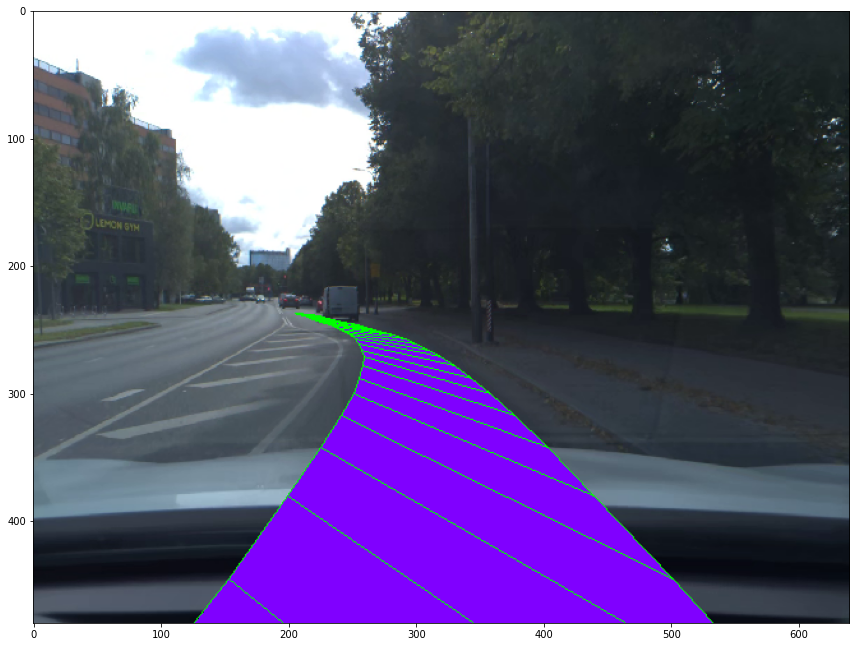

In [10]:
from common.transformations.camera import get_camera_frame_from_calib_frame, get_view_frame_from_road_frame, eon_intrinsics, img_from_device, denormalize, pretransform_from_calib
from common.transformations.orientation import euler2rot
from common.transformations.camera import view_frame_from_device_frame

path_xyz = best_path[0, 0, :, :3]


img = np.zeros((plot_img_height, plot_img_width, 3), dtype='uint8')
zoom_matrix = _BB_TO_FULL_FRAME
imgff = rgb_frame.copy()
cv2.warpAffine(imgff, zoom_matrix[:2], (img.shape[1], img.shape[0]), dst=img, flags=cv2.WARP_INVERSE_MAP)


# rpy_calib = [0.00018335809, 0.034165092, -0.014245722]  # real calibration values during this ride
rpy_calib = [0, 0, 0]  # calibration we used for creating ground truth
calibration = Calibration(rpy_calib)
draw_path(path_xyz, img, calibration)

plot_width = 15
plot_height = plot_width * (height / width)
plt.figure(figsize=(plot_width, plot_height))

# plt.scatter(u, v, 1, color='red')
plt.imshow(img)
plt.show()